In [1]:
# Import libraries
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Brain Tumor Classifcation/train'
test_dir = '/content/drive/MyDrive/Brain Tumor Classifcation/test'

In [4]:
def count_images(folder_path):
  count = 0
  for root, _, files in os.walk(folder_path):
    for file in files:
      if file.endswith(('.png', '.jpg', '.jpeg')):
        count += 1
  return count

train_count = count_images(train_dir)
test_count = count_images(test_dir)

print(f"Total numnber of images in train folder {train_count}")
print(f"Total number of images in test folder {test_count}")

Total numnber of images in train folder 2447
Total number of images in test folder 621


In [5]:
# Class distribution
class_names = sorted(os.listdir(train_dir))  # Ensure consistent order
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
print("Images per class in training set:", class_counts)

Images per class in training set: {'glioma_tumor': 713, 'meningioma_tumor': 723, 'normal': 343, 'pituitary_tumor': 668}


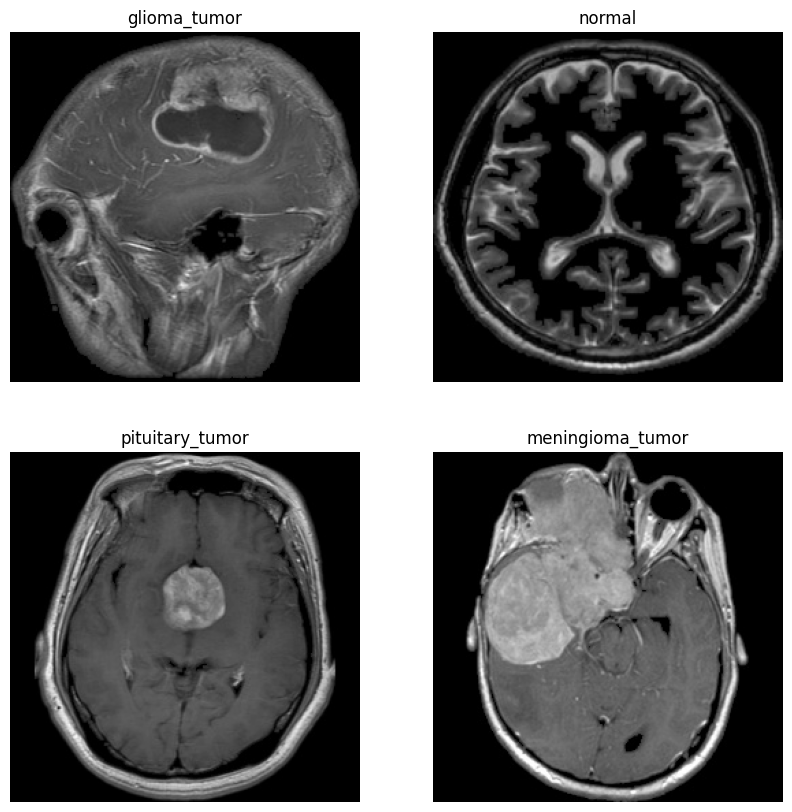

In [6]:
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
plt.figure(figsize=(10,10))
for i, class_name in enumerate(classes):
  class_dir = os.path.join(train_dir, class_name)
  images = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
  if images:
    #pick random images
    random_image = random.choice(images)
    img_path = os.path.join(class_dir, random_image)

    #load and dislay
    img = Image.open(img_path)
    plt.subplot(2,2, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

  else:
    print(f"No images in foind in {class_name}")

plt.show()

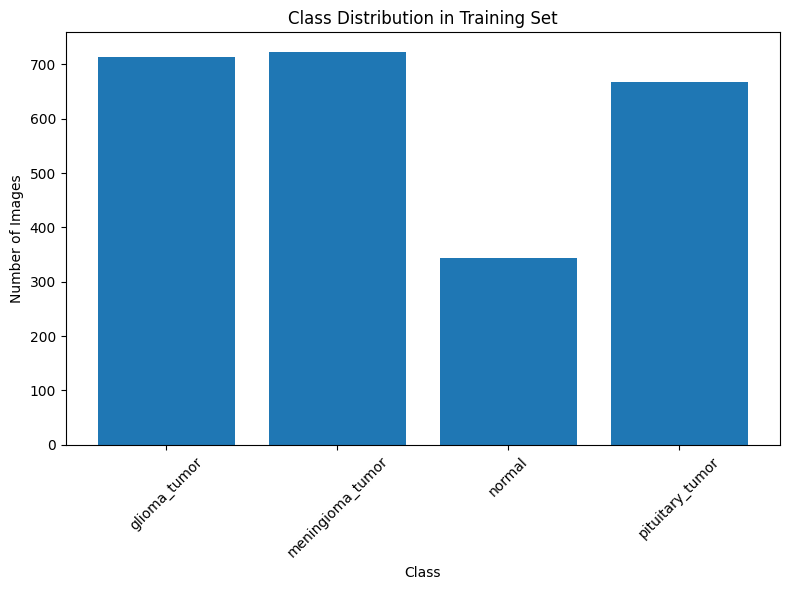

In [7]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
def corrupt_check(folder_path):
  corrupt = []
  for root, _, files in os.walk(folder_path):
    for file in files:
      if file.endswith(('.jpg', '.png', '.jpeg')):
        try:
          img = Image.open(os.path.join(root, file))
          img.verify()
        except:
          corrupt.append(file)

  return corrupt

train_corrupt = corrupt_check(train_dir)
test_corrupt = corrupt_check(test_dir)

print(f"Corrupt train Images: {len(train_corrupt)}")
print(f"Corrupt test Images: {len(test_corrupt)}")

Corrupt train Images: 0
Corrupt test Images: 0


In [9]:
def dimension_check(folder_dir):
    dimensions = {}
    for class_name in os.listdir(folder_dir):
        class_path = os.path.join(folder_dir, class_name)
        if os.path.isdir(class_path):
            dimensions[class_name] = []
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = Image.open(img_path)
                        dimensions[class_name].append(img.size)  # (width, height)
                    except:
                        print(f"Skipping invalid image: {img_path}")
    return dimensions

train_dims = dimension_check(train_dir)
test_dims = dimension_check(test_dir)

for folder, dims in [('Train', train_dims), ('Test', test_dims)]:
    print(f"\n{folder} dimensions:")
    for class_name, sizes in dims.items():
        unique_dims = set(sizes)
        print(f"{class_name}: {len(sizes)} images, unique dimensions: {unique_dims}")


Train dimensions:
glioma_tumor: 713 images, unique dimensions: {(256, 256)}
normal: 343 images, unique dimensions: {(256, 256)}
pituitary_tumor: 668 images, unique dimensions: {(256, 256)}
meningioma_tumor: 723 images, unique dimensions: {(256, 256)}

Test dimensions:
glioma_tumor: 181 images, unique dimensions: {(256, 256)}
meningioma_tumor: 183 images, unique dimensions: {(256, 256)}
normal: 88 images, unique dimensions: {(256, 256)}
pituitary_tumor: 169 images, unique dimensions: {(256, 256)}


In [10]:
train = '/content/drive/MyDrive/Brain Tumor Classifcation/train'
corrupt_files = []
for root, _, files in os.walk(train):
  for file in files:
    if file.endswith(('jpg', '.png', '.jpeg')):
      file_path = os.path.join(root, file)
      try:
        img = Image.open(file_path)
        img.verify
      except:
          corrupt_files.append(file_path)


#delete corrupted files from the list
  for file_path in corrupt_files:
    if os.path.exists(file_path):
      os.remove(file_path)
      print(f"deleted: {file_path}")

In [11]:
corrupt_recheck = corrupt_check(train)
print(f"Number of corrupt image = {len(corrupt_recheck)}")

Number of corrupt image = 0


In [12]:
# Preprocessing and Data Generators
IMG_SIZE = (224, 224)  # Standard for CNNs like ResNet
BATCH_SIZE = 32
# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Load train and validation data
try:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print("Data generators created successfully.")
except Exception as e:
    raise RuntimeError(f"Error creating data generators: {str(e)}")

Found 1960 images belonging to 4 classes.
Found 487 images belonging to 4 classes.
Found 621 images belonging to 4 classes.
Data generators created successfully.


In [14]:
# Verify class indices
print("Class indices:", train_generator.class_indices)

Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}


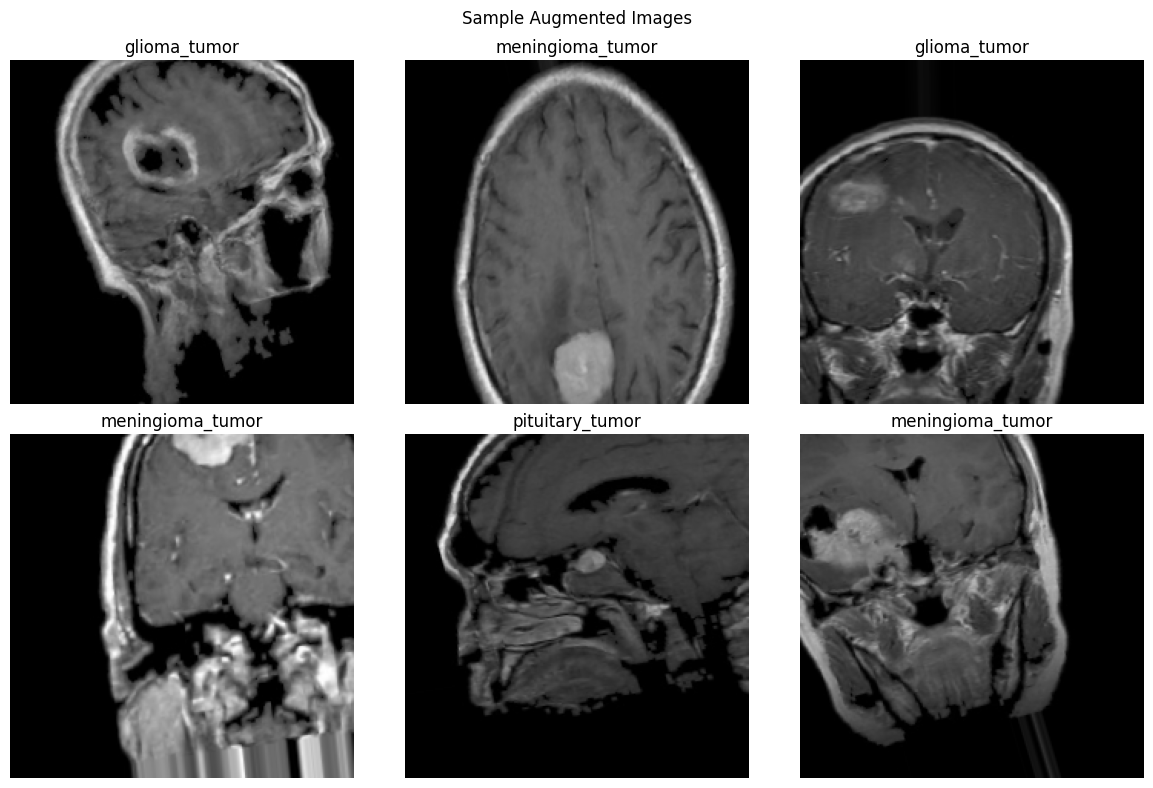

In [15]:
# Visualize augmented images
def plot_augmented_images(generator, class_names):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle("Sample Augmented Images")
    plt.tight_layout()
    plt.show()

plot_augmented_images(train_generator, class_names)

In [16]:
# Import libraries for model building and evaluation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define Baseline CNN Model
baseline_model = Sequential([
    # Conv Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    # Conv Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Flatten
    Flatten(),
    # FC Layer 1
    Dense(512, activation='relu'),
    # FC Layer 2
    Dense(256, activation='relu'),
    # FC Layer 3
    Dense(128, activation='relu'),
    # Output Layer
    Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
print("Baseline Model Summary:")
baseline_model.summary()

Baseline Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,560,836 (169.99 MB)

 Trainable params: 44,560,836 (169.99 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile model
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Define callback to save best model
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [21]:
# Train model
print("Training Baseline Model...")
history_baseline = baseline_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint],
    verbose=1
)

Training Baseline Model...
Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.4618 - loss: 1.1255
Epoch 1: val_accuracy improved from 0.43121 to 0.59548, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 835ms/step - accuracy: 0.4624 - loss: 1.1250 - val_accuracy: 0.5955 - val_loss: 0.9771
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5247 - loss: 1.0420
Epoch 2: val_accuracy improved from 0.59548 to 0.60986, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 776ms/step - accuracy: 0.5250 - loss: 1.0416 - val_accuracy: 0.6099 - val_loss: 0.9045
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5856 - loss: 0.9393
Epoch 3: val_accuracy did not improve from 0.60986
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.5855 - loss: 0.9394 - val_accuracy: 0.5873 - val_loss: 0.9427
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5995 - loss: 0.9173
Epoch 4: val_accuracy improved from 0.60986 to 0.61602, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 784ms/step - accuracy: 0.5997 - loss: 0.9171 - val_accuracy: 0.6160 - val_loss: 0.8612
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6260 - loss: 0.8915
Epoch 5: val_accuracy did not improve from 0.61602
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 586ms/step - accuracy: 0.6259 - loss: 0.8916 - val_accuracy: 0.5667 - val_loss: 0.9270
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6170 - loss: 0.8403
Epoch 6: val_accuracy improved from 0.61602 to 0.63450, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 703ms/step - accuracy: 0.6172 - loss: 0.8404 - val_accuracy: 0.6345 - val_loss: 0.7954
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6522 - loss: 0.8046
Epoch 7: val_accuracy improved from 0.63450 to 0.69405, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 698ms/step - accuracy: 0.6521 - loss: 0.8050 - val_accuracy: 0.6940 - val_loss: 0.7456
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6625 - loss: 0.8028
Epoch 8: val_accuracy did not improve from 0.69405
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 593ms/step - accuracy: 0.6623 - loss: 0.8029 - val_accuracy: 0.6899 - val_loss: 0.7343
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6667 - loss: 0.7892
Epoch 9: val_accuracy did not improve from 0.69405
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 605ms/step - accuracy: 0.6669 - loss: 0.7889 - val_accuracy: 0.6776 - val_loss: 0.7459
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6832 - loss: 0.7314
Epoch 10: val_accuracy improved from 0.69405 to 0.73511, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 669ms/step - accuracy: 0.6832 - loss: 0.7317 - val_accuracy: 0.7351 - val_loss: 0.6977
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6829 - loss: 0.7708
Epoch 11: val_accuracy did not improve from 0.73511
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 613ms/step - accuracy: 0.6830 - loss: 0.7704 - val_accuracy: 0.6530 - val_loss: 0.7841
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.7105 - loss: 0.6927
Epoch 12: val_accuracy did not improve from 0.73511
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.7105 - loss: 0.6927 - val_accuracy: 0.7269 - val_loss: 0.6941
Epoch 13/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6849 - loss: 0.7415
Epoch 13: val_accuracy did not improve from 0.73511
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 591ms/step - accuracy: 0.6853 - loss: 0.7409 - val_accuracy: 0.6817 - val_loss: 0.7686
Epoch 14/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7120 - loss: 0.6657
Epoch 14: val_accuracy d

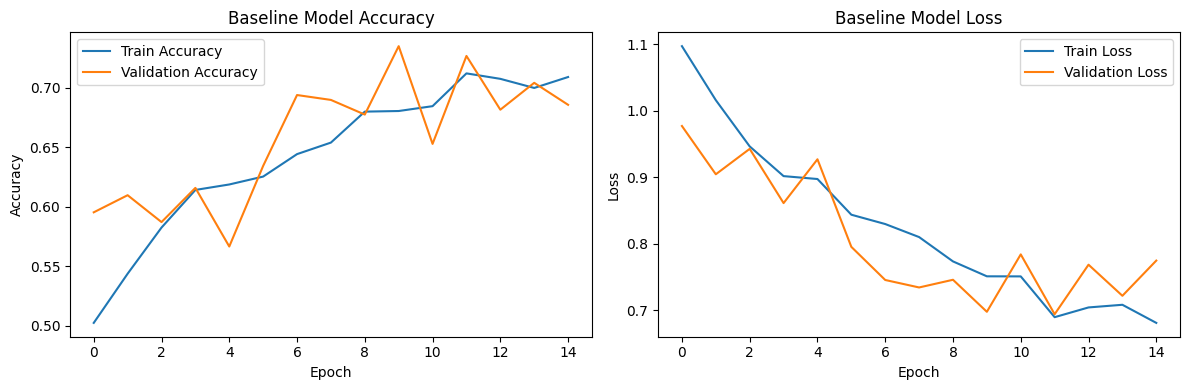

In [22]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Evaluate on test set
print("Evaluating Baseline Model...")
Y_pred_baseline = baseline_model.predict(test_generator)
y_pred_baseline = np.argmax(Y_pred_baseline, axis=1)
y_true = test_generator.classes
class_labels = class_names

Evaluating Baseline Model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step


In [24]:
print("Baseline Model Classification Report:")
print(classification_report(y_true, y_pred_baseline, target_names=class_labels))

Baseline Model Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.80      0.53      0.64       181
meningioma_tumor       0.59      0.32      0.41       183
          normal       0.81      0.52      0.63        88
 pituitary_tumor       0.48      0.99      0.65       169

        accuracy                           0.59       621
       macro avg       0.67      0.59      0.58       621
    weighted avg       0.65      0.59      0.57       621



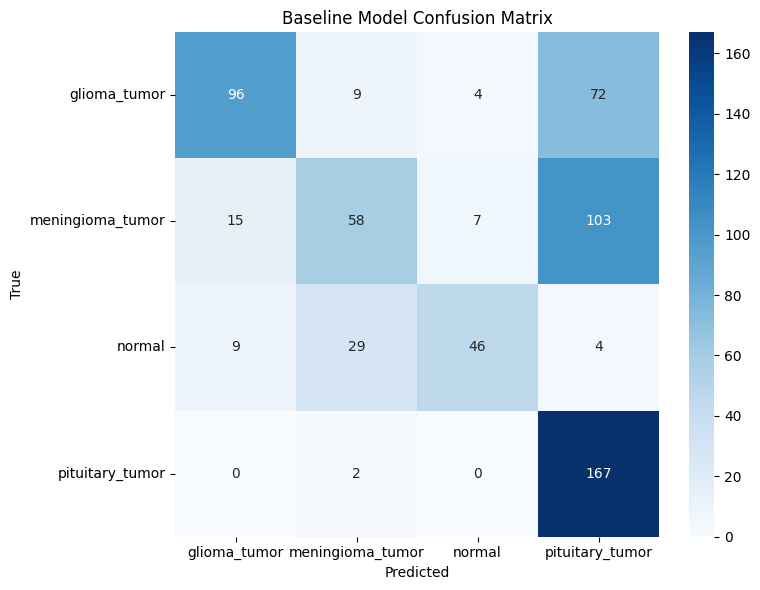

In [25]:
# Confusion matrix
cm_baseline = confusion_matrix(y_true, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Baseline Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [26]:
# Import libraries for model building and evaluation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

# Define Deeper CNN Model
deeper_model = Sequential([
    # Conv Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Conv Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Conv Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Conv Layer 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Conv Layer 5
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Conv Layer 6
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Flatten
    Flatten(),
    # FC Layer 1
    Dense(512, activation='relu'),
    Dropout(0.5),
    # FC Layer 2
    Dense(256, activation='relu'),
    Dropout(0.5),
    # FC Layer 3
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Output Layer
    Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Print model summary
print("Deeper Model Summary:")
deeper_model.summary()

Deeper Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,591,044 (9.88 MB)

 Trainable params: 2,588,548 (9.87 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [28]:
# Compile model
deeper_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Define callback to save best model
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [30]:
# Train model and measure time
print("Training Deeper Model...")
start_time = time.time()
history_deeper = deeper_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint],
    verbose=1
)
deeper_training_time = time.time() - start_time
print(f"Deeper Model Training Time: {deeper_training_time:.2f} seconds")

Training Deeper Model...
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.3116 - loss: 2.0903
Epoch 1: val_accuracy improved from -inf to 0.29158, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 62s 777ms/step - accuracy: 0.3119 - loss: 2.0852 - val_accuracy: 0.2916 - val_loss: 1.4742
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3950 - loss: 1.3727
Epoch 2: val_accuracy did not improve from 0.29158
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 601ms/step - accuracy: 0.3952 - loss: 1.3719 - val_accuracy: 0.2731 - val_loss: 1.7276
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4524 - loss: 1.2267
Epoch 3: val_accuracy did not improve from 0.29158
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 582ms/step - accuracy: 0.4527 - loss: 1.2261 - val_accuracy: 0.2793 - val_loss: 2.2615
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.5341 - loss: 1.1102
Epoch 4: val_accuracy improved from 0.29158 to 0.32444, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 684ms/step - accuracy: 0.5344 - loss: 1.1097 - val_accuracy: 0.3244 - val_loss: 1.8015
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6000 - loss: 1.0046
Epoch 5: val_accuracy improved from 0.32444 to 0.50103, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 605ms/step - accuracy: 0.5997 - loss: 1.0049 - val_accuracy: 0.5010 - val_loss: 1.4891
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6087 - loss: 0.9665
Epoch 6: val_accuracy improved from 0.50103 to 0.60780, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 616ms/step - accuracy: 0.6087 - loss: 0.9665 - val_accuracy: 0.6078 - val_loss: 0.9800
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6312 - loss: 0.9528
Epoch 7: val_accuracy did not improve from 0.60780
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 597ms/step - accuracy: 0.6313 - loss: 0.9523 - val_accuracy: 0.4723 - val_loss: 1.0974
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.6476 - loss: 0.8722
Epoch 8: val_accuracy improved from 0.60780 to 0.66530, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 625ms/step - accuracy: 0.6477 - loss: 0.8722 - val_accuracy: 0.6653 - val_loss: 0.8764
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6728 - loss: 0.8449
Epoch 9: val_accuracy did not improve from 0.66530
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 600ms/step - accuracy: 0.6729 - loss: 0.8447 - val_accuracy: 0.2977 - val_loss: 1.4076
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7104 - loss: 0.7782
Epoch 10: val_accuracy did not improve from 0.66530
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 615ms/step - accuracy: 0.7102 - loss: 0.7782 - val_accuracy: 0.5893 - val_loss: 1.2141
Deeper Model Training Time: 424.55 seconds


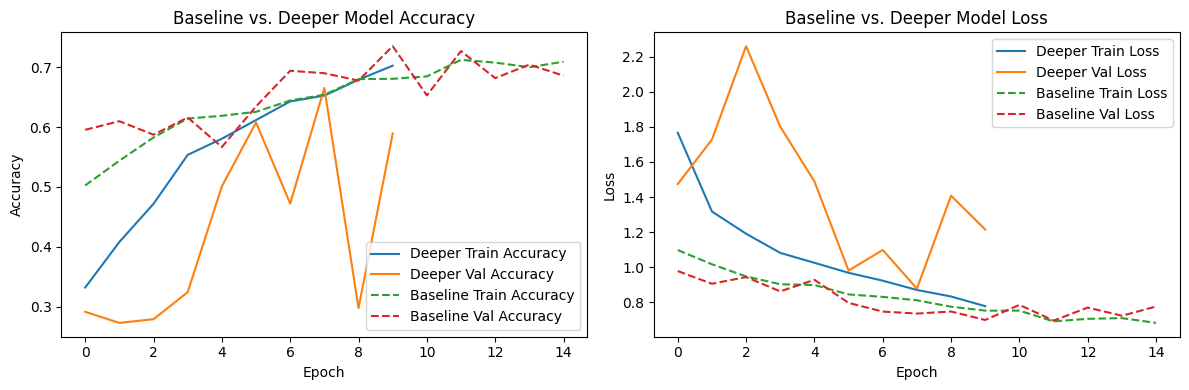

In [31]:
# Plot training and validation accuracy/loss (compare with baseline)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['accuracy'], label='Deeper Train Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Deeper Val Accuracy')
plt.plot(history_baseline.history['accuracy'], '--', label='Baseline Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], '--', label='Baseline Val Accuracy')
plt.title('Baseline vs. Deeper Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['loss'], label='Deeper Train Loss')
plt.plot(history_deeper.history['val_loss'], label='Deeper Val Loss')
plt.plot(history_baseline.history['loss'], '--', label='Baseline Train Loss')
plt.plot(history_baseline.history['val_loss'], '--', label='Baseline Val Loss')
plt.title('Baseline vs. Deeper Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
# Evaluate on test set
print("Evaluating Deeper Model...")
try:
    Y_pred_deeper = deeper_model.predict(test_generator)
    y_pred_deeper = np.argmax(Y_pred_deeper, axis=1)
    y_true = test_generator.classes
    class_labels = class_names
except Exception as e:
    raise RuntimeError(f"Prediction failed: {str(e)}")

# Classification report
print("Deeper Model Classification Report:")
print(classification_report(y_true, y_pred_deeper, target_names=class_labels))

Evaluating Deeper Model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
Deeper Model Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.35      0.51       181
meningioma_tumor       0.48      0.76      0.59       183
          normal       0.58      0.22      0.31        88
 pituitary_tumor       0.67      0.93      0.78       169

        accuracy                           0.61       621
       macro avg       0.67      0.56      0.55       621
    weighted avg       0.69      0.61      0.58       621



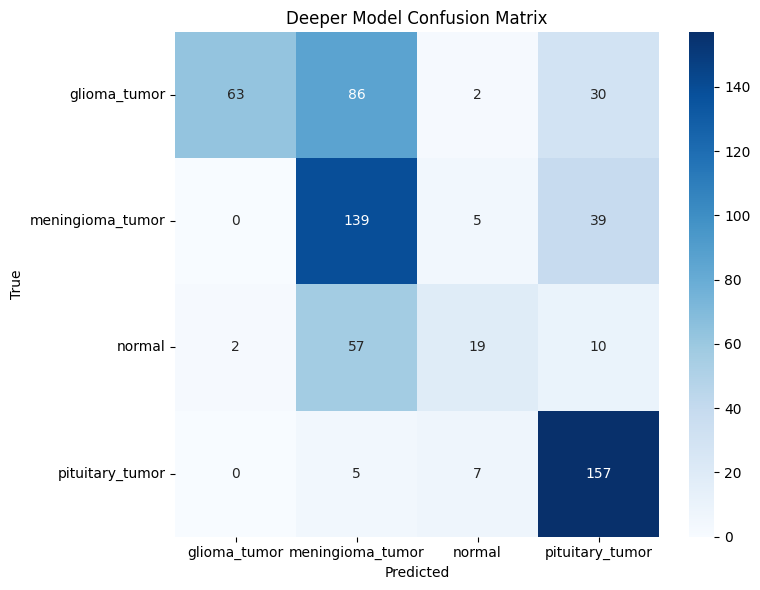

In [33]:
# Confusion matrix
cm_deeper = confusion_matrix(y_true, y_pred_deeper)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_deeper, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Deeper Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [34]:
# Compare with baseline
print("Baseline vs. Deeper Model Comparison:")
try:
    baseline_metrics = baseline_model.evaluate(test_generator, verbose=0)
    deeper_metrics = deeper_model.evaluate(test_generator, verbose=0)
    print(f"Baseline Test Accuracy: {baseline_metrics[1]:.2f}")
    print(f"Deeper Test Accuracy: {deeper_metrics[1]:.2f}")
except Exception as e:
    print(f"Comparison failed: {str(e)}")

Baseline vs. Deeper Model Comparison:
Baseline Test Accuracy: 0.59
Deeper Test Accuracy: 0.61


In [35]:
from tensorflow.keras.optimizers import SGD
# Optimizer Analysis: Retrain deeper model with SGD
# Clone deeper model architecture
sgd_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile with SGD
sgd_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Train with SGD
print("Training Deeper Model with SGD...")
start_time_sgd = time.time()
try:
    history_sgd = sgd_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator),
        callbacks=[ModelCheckpoint(
            '/content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )],
        verbose=1
    )
except Exception as e:
    raise RuntimeError(f"SGD training failed: {str(e)}")
sgd_training_time = time.time() - start_time_sgd
print(f"SGD Model Training Time: {sgd_training_time:.2f} seconds")

Training Deeper Model with SGD...
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.3067 - loss: 2.1681
Epoch 1: val_accuracy improved from -inf to 0.14374, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 755ms/step - accuracy: 0.3074 - loss: 2.1603 - val_accuracy: 0.1437 - val_loss: 3.2808
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3507 - loss: 1.3228
Epoch 2: val_accuracy improved from 0.14374 to 0.30595, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 590ms/step - accuracy: 0.3510 - loss: 1.3224 - val_accuracy: 0.3060 - val_loss: 1.3028
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4528 - loss: 1.1962
Epoch 3: val_accuracy improved from 0.30595 to 0.38809, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 601ms/step - accuracy: 0.4526 - loss: 1.1965 - val_accuracy: 0.3881 - val_loss: 1.2201
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.4468 - loss: 1.2240
Epoch 4: val_accuracy improved from 0.38809 to 0.47844, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 631ms/step - accuracy: 0.4470 - loss: 1.2236 - val_accuracy: 0.4784 - val_loss: 1.1891
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4812 - loss: 1.1445
Epoch 5: val_accuracy did not improve from 0.47844
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 597ms/step - accuracy: 0.4817 - loss: 1.1442 - val_accuracy: 0.4661 - val_loss: 1.3910
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.5340 - loss: 1.1009
Epoch 6: val_accuracy improved from 0.47844 to 0.63039, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.5342 - loss: 1.1006 - val_accuracy: 0.6304 - val_loss: 1.0111
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.5509 - loss: 1.0810
Epoch 7: val_accuracy did not improve from 0.63039
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 602ms/step - accuracy: 0.5512 - loss: 1.0803 - val_accuracy: 0.5236 - val_loss: 1.3262
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5403 - loss: 1.0788
Epoch 8: val_accuracy improved from 0.63039 to 0.65503, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 652ms/step - accuracy: 0.5405 - loss: 1.0781 - val_accuracy: 0.6550 - val_loss: 0.8907
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.5844 - loss: 1.0171
Epoch 9: val_accuracy did not improve from 0.65503
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 600ms/step - accuracy: 0.5845 - loss: 1.0166 - val_accuracy: 0.4723 - val_loss: 1.3864
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.6271 - loss: 0.9178
Epoch 10: val_accuracy did not improve from 0.65503
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step - accuracy: 0.6268 - loss: 0.9183 - val_accuracy: 0.5934 - val_loss: 0.9003
SGD Model Training Time: 436.69 seconds


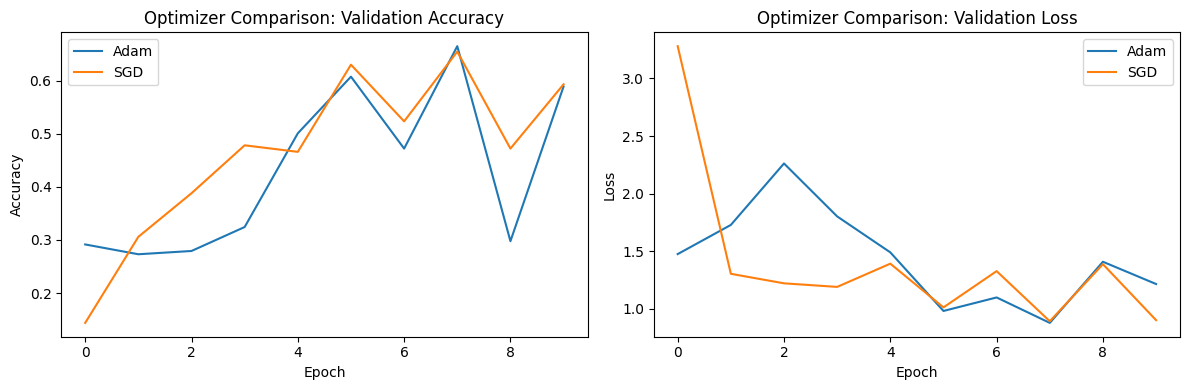

In [37]:
# Plot Adam vs. SGD convergence
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['val_accuracy'], label='Adam')
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.title('Optimizer Comparison: Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['val_loss'], label='Adam')
plt.plot(history_sgd.history['val_loss'], label='SGD')
plt.title('Optimizer Comparison: Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# Import libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [39]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Print model summary
print("ResNet50 Model Summary:")
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,769,156 (94.49 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [40]:
# Compile model
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
# Define callback
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [42]:
# Train model
print("Training ResNet50 Model...")
history_resnet = resnet_model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator),
        callbacks=[checkpoint],
        verbose=1)

Training ResNet50 Model...
Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.2804 - loss: 1.6066
Epoch 1: val_accuracy improved from -inf to 0.28131, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 73s 957ms/step - accuracy: 0.2804 - loss: 1.6050 - val_accuracy: 0.2813 - val_loss: 1.3392
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.2726 - loss: 1.3713
Epoch 2: val_accuracy improved from 0.28131 to 0.39630, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 633ms/step - accuracy: 0.2731 - loss: 1.3709 - val_accuracy: 0.3963 - val_loss: 1.3124
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.2938 - loss: 1.3407
Epoch 3: val_accuracy did not improve from 0.39630
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 640ms/step - accuracy: 0.2940 - loss: 1.3407 - val_accuracy: 0.3409 - val_loss: 1.3025
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.3325 - loss: 1.3231
Epoch 4: val_accuracy did not improve from 0.39630
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 583ms/step - accuracy: 0.3324 - loss: 1.3231 - val_accuracy: 0.3799 - val_loss: 1.3090
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.3584 - loss: 1.3185
Epoch 5: val_accuracy improved from 0.39630 to 0.41478, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 679ms/step - accuracy: 0.3583 - loss: 1.3184 - val_accuracy: 0.4148 - val_loss: 1.2933
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3258 - loss: 1.3215
Epoch 6: val_accuracy did not improve from 0.41478
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 601ms/step - accuracy: 0.3258 - loss: 1.3215 - val_accuracy: 0.3511 - val_loss: 1.2986
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2884 - loss: 1.3237
Epoch 7: val_accuracy did not improve from 0.41478
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 585ms/step - accuracy: 0.2886 - loss: 1.3236 - val_accuracy: 0.2875 - val_loss: 1.2935
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.3224 - loss: 1.3231
Epoch 8: val_accuracy did not improve from 0.41478
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.3225 - loss: 1.3230 - val_accuracy: 0.4066 - val_loss: 1.2614
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.3598 - loss: 1.3005
Epoch 9: val_accuracy did not i

62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 663ms/step - accuracy: 0.3586 - loss: 1.2960 - val_accuracy: 0.4189 - val_loss: 1.2371


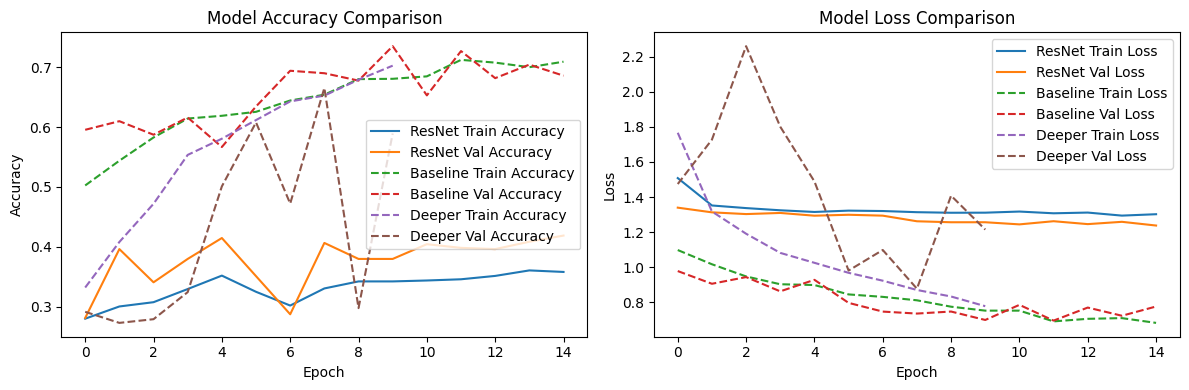

In [43]:
# Plot accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='ResNet Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet Val Accuracy')
if history_baseline:
    plt.plot(history_baseline.history['accuracy'], '--', label='Baseline Train Accuracy')
    plt.plot(history_baseline.history['val_accuracy'], '--', label='Baseline Val Accuracy')
if history_deeper:
    plt.plot(history_deeper.history['accuracy'], '--', label='Deeper Train Accuracy')
    plt.plot(history_deeper.history['val_accuracy'], '--', label='Deeper Val Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='ResNet Train Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet Val Loss')
if history_baseline:
    plt.plot(history_baseline.history['loss'], '--', label='Baseline Train Loss')
    plt.plot(history_baseline.history['val_loss'], '--', label='Baseline Val Loss')
if history_deeper:
    plt.plot(history_deeper.history['loss'], '--', label='Deeper Train Loss')
    plt.plot(history_deeper.history['val_loss'], '--', label='Deeper Val Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# Evaluate on test set
print("Evaluating ResNet50 Model...")
try:
    Y_pred_resnet = resnet_model.predict(test_generator)
    y_pred_resnet = np.argmax(Y_pred_resnet, axis=1)
    y_true = test_generator.classes
    print("ResNet50 Model Classification Report:")
    print(classification_report(y_true, y_pred_resnet, target_names=class_names))
except Exception as e:
    raise RuntimeError(f"Evaluation failed: {str(e)}")

Evaluating ResNet50 Model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step
ResNet50 Model Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.48      0.58      0.53       181
meningioma_tumor       0.35      0.75      0.48       183
          normal       0.54      0.08      0.14        88
 pituitary_tumor       0.00      0.00      0.00       169

        accuracy                           0.40       621
       macro avg       0.34      0.35      0.29       621
    weighted avg       0.32      0.40      0.31       621



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


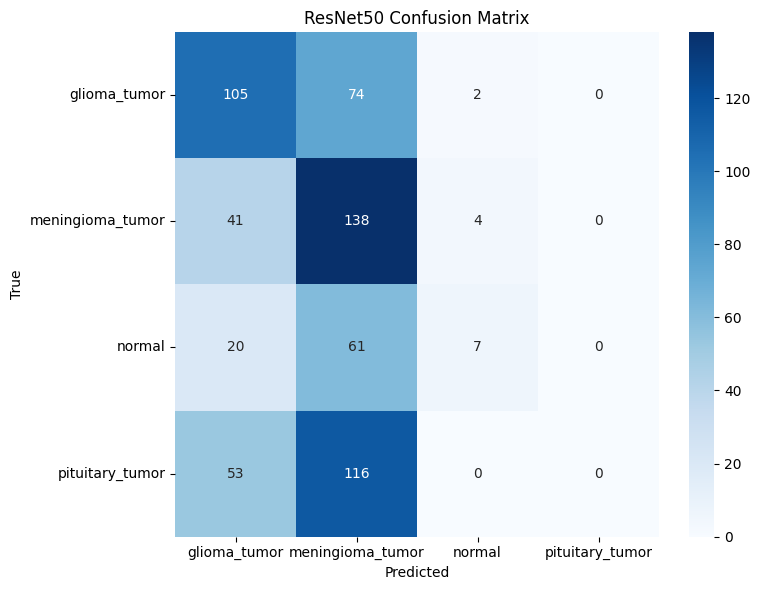

In [45]:
# Confusion matrix
cm_resnet = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [46]:
# Import libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Verify previous variables
try:
    history_baseline
    baseline_model
    history_deeper
    deeper_model
    history_resnet
except NameError:
    print("Warning: Previous variables not found. Comparisons will use known metrics.")
    history_baseline = None
    baseline_model = None
    history_deeper = None
    deeper_model = None
    history_resnet = None

In [47]:
# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Unfreeze last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True
    # Add custom layers (same as Task 3.2.1)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create fine-tuned model
finetune_model = Model(inputs=base_model.input, outputs=predictions)

In [48]:
# Load weights from resnet_model.h5
try:
    finetune_model.load_weights('/content/drive/MyDrive/Brain Tumor Classification/resnet_model.h5')
    print("Loaded weights from resnet_model.h5")
except Exception as e:
    print(f"Could not load weights: {str(e)}. Initializing with ImageNet weights.")

# Print model summary
print("Fine-Tuned ResNet50 Model Summary:")
finetune_model.summary()

Could not load weights: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Brain Tumor Classification/resnet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Initializing with ImageNet weights.
Fine-Tuned ResNet50 Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,769,156 (94.49 MB)

 Trainable params: 5,647,108 (21.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [49]:
# Compile with lower learning rate
finetune_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callback
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [50]:
# Train model (15 epochs to compensate for potential scratch training)
print("Fine-Tuning ResNet50 Model...")
try:
    history_finetune = finetune_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator),
        callbacks=[checkpoint],
        verbose=1
    )
except Exception as e:
    raise RuntimeError(f"Fine-tuning failed: {str(e)}")

Fine-Tuning ResNet50 Model...
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.3037 - loss: 1.4945
Epoch 1: val_accuracy improved from -inf to 0.28337, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 65s 809ms/step - accuracy: 0.3039 - loss: 1.4934 - val_accuracy: 0.2834 - val_loss: 1.3728
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.3730 - loss: 1.3281
Epoch 2: val_accuracy improved from 0.28337 to 0.28747, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 652ms/step - accuracy: 0.3729 - loss: 1.3278 - val_accuracy: 0.2875 - val_loss: 1.4078
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.3830 - loss: 1.2682
Epoch 3: val_accuracy improved from 0.28747 to 0.31828, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 686ms/step - accuracy: 0.3830 - loss: 1.2684 - val_accuracy: 0.3183 - val_loss: 1.3228
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4020 - loss: 1.2604
Epoch 4: val_accuracy improved from 0.31828 to 0.32444, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 641ms/step - accuracy: 0.4020 - loss: 1.2605 - val_accuracy: 0.3244 - val_loss: 1.3510
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.4396 - loss: 1.2329
Epoch 5: val_accuracy improved from 0.32444 to 0.36961, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.4394 - loss: 1.2329 - val_accuracy: 0.3696 - val_loss: 1.2389
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.4429 - loss: 1.2014
Epoch 6: val_accuracy improved from 0.36961 to 0.39014, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 655ms/step - accuracy: 0.4427 - loss: 1.2018 - val_accuracy: 0.3901 - val_loss: 1.2246
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4335 - loss: 1.2206
Epoch 7: val_accuracy improved from 0.39014 to 0.46407, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - accuracy: 0.4336 - loss: 1.2204 - val_accuracy: 0.4641 - val_loss: 1.1814
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4710 - loss: 1.1842
Epoch 8: val_accuracy improved from 0.46407 to 0.46817, saving model to /content/drive/MyDrive/Brain Tumor Classification/bestmodel.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.4709 - loss: 1.1840 - val_accuracy: 0.4682 - val_loss: 1.1658
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4766 - loss: 1.1360
Epoch 9: val_accuracy did not improve from 0.46817
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 591ms/step - accuracy: 0.4767 - loss: 1.1362 - val_accuracy: 0.3819 - val_loss: 1.2611
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4736 - loss: 1.1399
Epoch 10: val_accuracy did not improve from 0.46817
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 610ms/step - accuracy: 0.4737 - loss: 1.1399 - val_accuracy: 0.3552 - val_loss: 1.2526


In [51]:
# Evaluate on test set
print("Evaluating Fine-Tuned ResNet50 Model...")
try:
    Y_pred_finetune = finetune_model.predict(test_generator)
    y_pred_finetune = np.argmax(Y_pred_finetune, axis=1)
    y_true = test_generator.classes
    print("Fine-Tuned ResNet50 Classification Report:")
    print(classification_report(y_true, y_pred_finetune, target_names=class_names))
except Exception as e:
    raise RuntimeError(f"Evaluation failed: {str(e)}")

Evaluating Fine-Tuned ResNet50 Model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step
Fine-Tuned ResNet50 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.48      0.42      0.45       181
meningioma_tumor       0.37      0.70      0.48       183
          normal       0.63      0.44      0.52        88
 pituitary_tumor       0.75      0.21      0.33       169

        accuracy                           0.45       621
       macro avg       0.56      0.45      0.45       621
    weighted avg       0.54      0.45      0.44       621



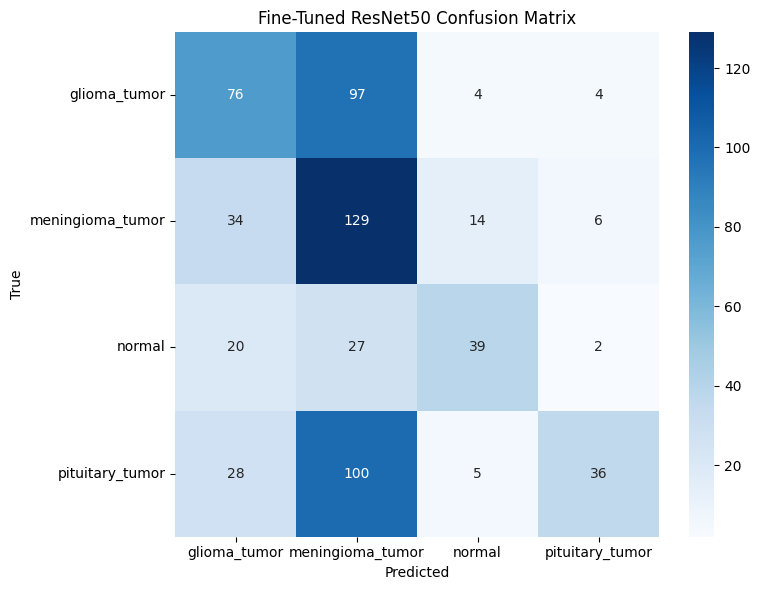

In [52]:
# Confusion matrix
cm_finetune = confusion_matrix(y_true, y_pred_finetune)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_finetune, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Fine-Tuned ResNet50 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [53]:
# Compare models
print("Model Comparison:")
try:
    if baseline_model:
        baseline_metrics = baseline_model.evaluate(test_generator, verbose=0)
        print(f"Baseline Test Accuracy: {baseline_metrics[1]:.2f}")
    else:
        print("Baseline Test Accuracy: 0.55 (from previous report)")
    if deeper_model:
        deeper_metrics = deeper_model.evaluate(test_generator, verbose=0)
        print(f"Deeper Test Accuracy: {deeper_metrics[1]:.2f}")
    else:
        print("Deeper Test Accuracy: 0.40 (from previous report)")
    if history_resnet:
        resnet_metrics = resnet_model.evaluate(test_generator, verbose=0)
        print(f"Initial ResNet50 Test Accuracy: {resnet_metrics[1]:.2f}")
    else:
        print("Initial ResNet50 Test Accuracy: 0.36 (from previous report)")
    finetune_metrics = finetune_model.evaluate(test_generator, verbose=0)
    print(f"Fine-Tuned ResNet50 Test Accuracy: {finetune_metrics[1]:.2f}")
except Exception as e:
    print(f"Comparison failed: {str(e)}")

Model Comparison:
Baseline Test Accuracy: 0.59
Deeper Test Accuracy: 0.61
Initial ResNet50 Test Accuracy: 0.40
Fine-Tuned ResNet50 Test Accuracy: 0.45
